In [17]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn import preprocessing
from timeit import default_timer as timer
from sklearn.externals import joblib

from sklearn.model_selection import RandomizedSearchCV

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)

train.isnull().values.any()
train.head(10)
#print(sum(train['percent_atom_ga']+train['percent_atom_al']+train['percent_atom_in']))

(2400, 14)


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793
5,6,227,40.0,0.5625,0.4375,0.000,9.8456,5.7176,14.1244,91.1235,91.3033,30.5730,0.2209,2.1633
6,7,206,80.0,0.0312,0.0938,0.875,10.1664,10.1664,10.1666,90.0009,90.0008,89.9987,0.0562,0.9854
7,8,12,20.0,0.5000,0.0000,0.500,12.1350,3.1533,6.2880,89.9997,105.1790,90.0001,0.2243,1.7179
8,9,206,80.0,0.5312,0.2188,0.250,9.4027,9.4023,9.4025,90.0025,90.0030,89.9978,0.2193,2.6257
9,10,194,80.0,0.4062,0.5938,0.000,6.2520,6.2520,23.7931,90.0172,89.9994,119.9997,0.1994,2.5187


In [18]:
vars=train.columns
    

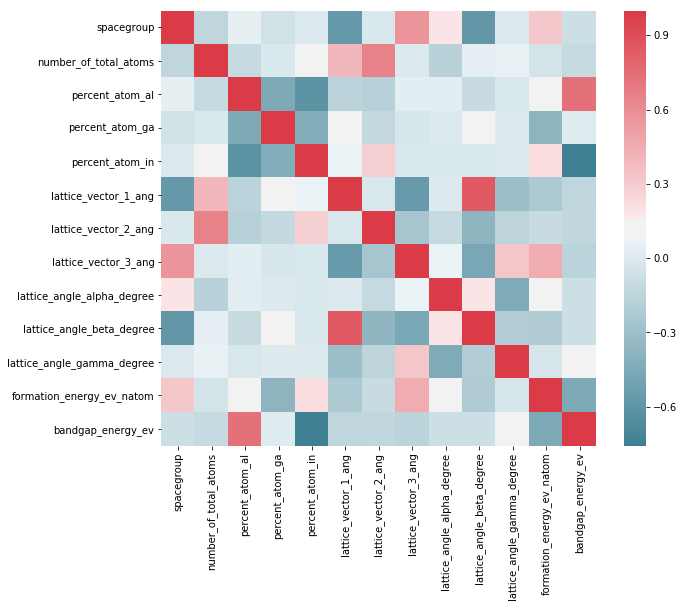

In [19]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = train[vars[1:]].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [20]:
target_fe = np.log1p(train.formation_energy_ev_natom)
target_be = np.log1p(train.bandgap_energy_ev)
#target_fe = (train.formation_energy_ev_natom)
#target_be = (train.bandgap_energy_ev)

train['number_of_total_atoms']=train['number_of_total_atoms'].astype(int)
test['number_of_total_atoms']=test['number_of_total_atoms'].astype(int)
test_id=test.id
del train['formation_energy_ev_natom'], train['bandgap_energy_ev'], train['id'], test['id']
#del train['percent_atom_ga'], test['percent_atom_ga']


In [21]:
train = pd.concat([train.drop(['spacegroup'], axis=1), 
                   pd.get_dummies(train['spacegroup'], prefix='SG')], axis=1)
test = pd.concat([test.drop(['spacegroup'], axis=1), 
                   pd.get_dummies(test['spacegroup'], prefix='SG')], axis=1)
train = pd.concat([train.drop(['number_of_total_atoms'], axis=1), 
                   pd.get_dummies(train['number_of_total_atoms'], prefix='NAT')], axis=1)
test = pd.concat([test.drop(['number_of_total_atoms'], axis=1), 
                   pd.get_dummies(test['number_of_total_atoms'], prefix='NAT')], axis=1)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train_fe, y_test_fe = train_test_split(train, target_fe, test_size=test_size, random_state=seed)
X_train, X_test, y_train_be, y_test_be = train_test_split(train, target_be, test_size=test_size, random_state=seed)

#X_train = preprocessing.scale(X_train)
#X_test  = preprocessing.scale(X_test)


In [6]:

#list(test)
#print(1/np.sqrt(len(train)))
#search for best model 
model=XGBRegressor()
search_params = {
    'max_depth':list(range(1,10,1)),
    'n_estimators':list(range(10,500,10)),
    'gamma':list(np.arange(0.,1,.05)),
    'min_child_weight':list(np.arange(0.1,1,.1)),
    'colsample_bytree':list(np.arange(0.1,1,.05)), 
    'learning_rate':list(np.arange(0.01,0.1,0.01))
}
search = RandomizedSearchCV(model, search_params, n_iter=10000)
#search.fit(X_train, y_train_be)
search.fit(X_train, y_train_fe)
print(search.best_params_)

{'n_estimators': 160, 'colsample_bytree': 0.45000000000000007, 'gamma': 0.0, 'learning_rate': 0.050000000000000003, 'min_child_weight': 0.10000000000000001, 'max_depth': 3}


In [7]:



# fit model no training data
#fe:
model = XGBRegressor(gamma=0.0,max_depth=3,n_estimators=160,learning_rate=0.05,min_child_weight=0.10,colsample_bytree=0.45, seed=7)
#be:
#model = XGBRegressor(gamma=0.0,max_depth=2,n_estimators=460,learning_rate=0.09,min_child_weight=0.40,colsample_bytree=0.15, seed=7)
#start = timer()
model.fit(X_train, y_train_fe)
#model.fit(X_train, y_train_be)
#end = timer()


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0.0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=0.1, missing=None, n_estimators=160, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

In [9]:
#print('executation time : ', (end - start))  
print(model)
filename = 'finalized_model_fe.sav'
#filename = 'finalized_model_be.sav'
joblib.dump(model, filename)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0.0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=0.1, missing=None, n_estimators=160, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)


['finalized_model_fe.sav']

In [10]:
y_pred = model.predict(X_test)


In [11]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [12]:


accuracy = rmsle(list(y_test_fe), list(y_pred))
#accuracy = rmsle(list(y_test_be), list(y_pred))
print("rmsle: %.5f%%" % (accuracy))

rmsle: 0.02775%


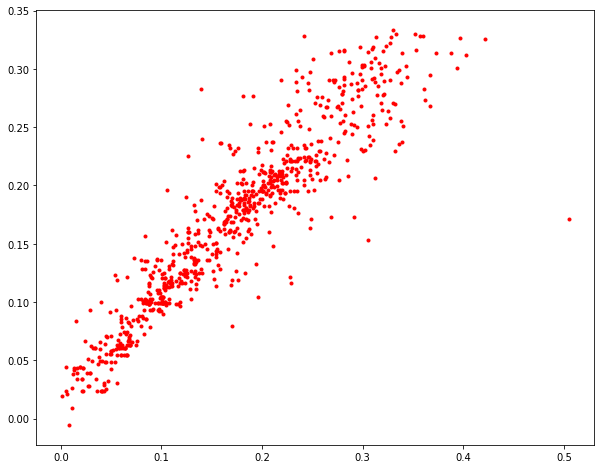

In [13]:
f, ax = plt.subplots(figsize=(10, 8))
plt.plot(y_test_fe, y_pred,'r.')
#plt.ylim((0,0.4))
#plt.xlim((0,0.4))
plt.show()


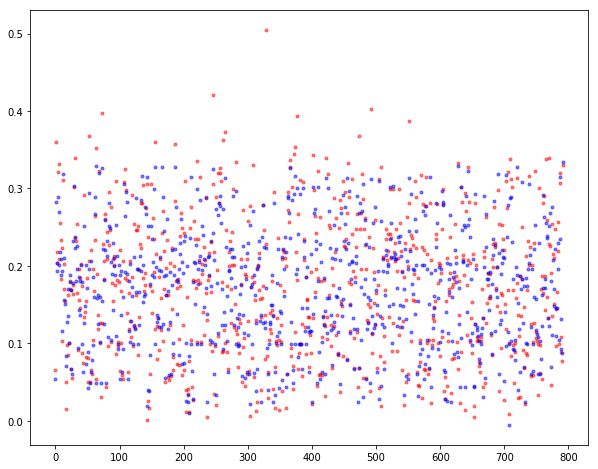

In [14]:
f, ax = plt.subplots(figsize=(10, 8))
plt.plot(range(0,792),y_test_fe, 'r.', alpha=.5)
plt.plot(range(0,792),y_pred, 'b.', alpha=.5)
plt.show()


In [49]:
filename = 'finalized_model_fe.sav'
loaded_model_fe = joblib.load(filename)
filename = 'finalized_model_be.sav'
loaded_model_be = joblib.load(filename)


In [50]:
fe = loaded_model_fe.predict(test)
be = loaded_model_be.predict(test)
sub=pd.DataFrame()
sub["id"]=test_id
sub["formation_energy_ev_natom"]=np.expm1(fe)
sub[sub<0]=0
sub["bandgap_energy_ev"]=np.expm1(be)

sub.to_csv("final_result.csv",index=False)
sub.head(10)
           

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.188614,1.458907
1,2,0.070020,3.738870
2,3,0.147171,3.565568
3,4,0.025684,2.898391
4,5,0.134286,1.550186
5,6,0.076822,4.739800
6,7,0.068899,3.260590
7,8,0.122948,2.031813
8,9,0.069121,2.717016
9,10,0.232819,2.957316


In [40]:
len(sub)


600

In [41]:
min(sub['formation_energy_ev_natom'])

0.0

In [38]:
sum(sub['formation_energy_ev_natom']<0)

0

In [48]:
sub.head(369)

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.188614,1.458907
1,2,0.070020,3.738870
2,3,0.147171,3.565568
3,4,0.025684,2.898391
4,5,0.134286,1.550186
5,6,0.076822,4.739800
6,7,0.068899,3.260590
7,8,0.122948,2.031813
8,9,0.069121,2.717016
9,10,0.232819,2.957316


TypeError: unhashable type: 'slice'